In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [20]:
num_classes=10
# Let us define some paths first
input_path = "./input/"

# Path to training images and corresponding labels provided as numpy arrays
kmnist_train_images_path = input_path+"kmnist-train-imgs.npz"
kmnist_train_labels_path = input_path+"kmnist-train-labels.npz"

# Path to the test images and corresponding labels
kmnist_test_images_path = input_path+"kmnist-test-imgs.npz"
kmnist_test_labels_path = input_path+"kmnist-test-labels.npz"

# Load the training data from the corresponding npz files
kmnist_train_images = np.load(kmnist_train_images_path)['arr_0']
kmnist_train_labels = np.load(kmnist_train_labels_path)['arr_0']

# Load the test data from the corresponding npz files
kmnist_test_images = np.load(kmnist_test_images_path)['arr_0']
kmnist_test_labels = np.load(kmnist_test_labels_path)['arr_0']

kmnist_train_labels = keras.utils.to_categorical(kmnist_train_labels, num_classes)
kmnist_test_labels = keras.utils.to_categorical(kmnist_test_labels, num_classes)
print(f"Number of training samples: {len(kmnist_train_images)} where each sample is of size: {kmnist_train_images.shape[1:]}")
print(f"Number of test samples: {len(kmnist_test_images)} where each sample is of size: {kmnist_test_images.shape[1:]}")

train_ds_kmnist = tf.data.Dataset.from_tensor_slices((kmnist_train_images, kmnist_train_labels))
test_ds_kmnist = tf.data.Dataset.from_tensor_slices((kmnist_test_images, kmnist_test_labels))
def augment_images(image, label,input_size=(227,227), channel_first = False):
        # Normalize images to have a mean of 0 and standard deviation of 1
        # image = tf.image.per_image_standardization(image)
        # Resize images from 32x32 to 277x277
        image = tf.reshape(image, (28,28,1))
        # image = tf.image.grayscale_to_rgb(image, name=None)
        # image = tf.image.resize(image,input_size)
        if channel_first:
            image = tf.transpose(image, [2, 0, 1])

        return image, label
batch_size=32
train_ds_kmnist_size = len(list(train_ds_kmnist))
train_ds_kmnist = (train_ds_kmnist
                .map(augment_images)
                .shuffle(buffer_size=train_ds_kmnist_size,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds_kmnist = (test_ds_kmnist
                .map(augment_images)
                #   .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=batch_size, drop_remainder=True))



Number of training samples: 60000 where each sample is of size: (28, 28)
Number of test samples: 10000 where each sample is of size: (28, 28)


In [4]:
def dataset():
    num_outputs = 10
    validation_size = 5000
    batch_size = 32
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    train_labels = tf.keras.utils.to_categorical(train_labels,num_outputs)
    test_labels = tf.keras.utils.to_categorical(test_labels,num_outputs)
    
    validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
    train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
    
    def augment_images(image, label,input_size=(227,227), channel_first = False):
        # Normalize images to have a mean of 0 and standard deviation of 1
        # image = tf.image.per_image_standardization(image)
        # Resize images from 32x32 to 277x277
        image = tf.reshape(image, (28,28,1))
        # image = tf.image.grayscale_to_rgb(image, name=None)
        # image = tf.image.resize(image,input_size)
        if channel_first:
            image = tf.transpose(image, [2, 0, 1])

        return image, label



    train_ds_size = len(list(train_ds))
    test_ds_size = len(list(test_ds))
    validation_ds_size = len(list(validation_ds))

    print("trainSize {}".format(train_ds_size))
    print("testSize {}".format(test_ds_size))

    train_ds = (train_ds
                    .map(augment_images)
                    .shuffle(buffer_size=train_ds_size,seed=42,reshuffle_each_iteration=False)
                    .batch(batch_size=batch_size, drop_remainder=True))

    test_ds = (test_ds
                    # .map(augment_images)
                    #   .shuffle(buffer_size=train_ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))

    validation_ds = (validation_ds
                    # .map(augment_images)
                    #   .shuffle(buffer_size=validation_ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))

    return (train_ds, test_ds, validation_ds)

train_ds, test_ds, validation_ds = dataset()

trainSize 55000
testSize 10000


In [5]:
def rotateImg(model, digit_one, evidence_func = tf.nn.relu, verbose=False):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        evidence =evidence_func(_pred)
        
        if verbose:
            print(_pred, evidence, "label", np.argmax(_pred))
        alpha = evidence 
        
        # alpha = exp_evidence(logits)
        # S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        # E = alpha - 1
    
        # A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
        
        
        u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
        # print("uncert",u)
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        
        # print("prob", evidence)
        # print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
        print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        # print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)

    print(labels)
    for j in range(len(labels)):
        plt.plot(ldeg,lp[:,j],marker=marker[j])
    labels += ['uncertainty']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass')
    # plt.yscale("log")
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    return(uncert)

In [6]:
def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl
  # return (px.pdf(X) * (log(px.pdf(X)) - log(qx.pdf(X)))).sum()

def _KL(alpha, beta, K ):
    # print("K:",K)
    # beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    beta = tf.cast(beta,tf.float32)
    alpha = tf.cast(alpha,tf.float32)
    S_alpha = tf.reduce_sum(alpha,keepdims=True)
    S_beta = tf.reduce_sum(beta,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

import tensorflow.python.keras.backend as K


current_epoch = K.variable(0.)
        
        
class changeAlpha(tf.keras.callbacks.Callback):
    def __init__(self):
        super(changeAlpha, self).__init__()
        self.current_epoch = current_epoch
    def on_epoch_begin(self, epoch, logs={}):

        K.set_value(self.current_epoch, epoch)
        tf.print("current epoch", K.get_value(current_epoch))

        
        
def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function




In [47]:
KL(tf.Variable([[1.0,1.0,1.0,50.0,1.0,1.0,1.0,1.0,1.0,1.0]]),10)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[14.903325]], dtype=float32)>

In [44]:
beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
_KL(tf.Variable([[1.0,1.0,1.0,1.0,1.0,50,1.0,1.0,1.0,1.0]]),beta,10)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[14.903325]], dtype=float32)>

In [53]:
beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
_KL(beta,tf.Variable([[1.0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0]]),10)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.9518337]], dtype=float32)>

In [54]:
KKL = tf.keras.activations.KL()
# return (px.pdf(X) * (log(px.pdf(X)) - log(qx.pdf(X)))).sum()

AttributeError: module 'keras.api._v2.keras.activations' has no attribute 'KL'

In [14]:
batch_size = 128
epochs = 15

# model = keras.Sequential(
#     [
#         keras.Input(shape=input_shape),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes),
#     ]
# )
# def justKL(labels,inputs):
def dirichlet_kl_divergence(alphas, target_alphas, precision=None, target_precision=None,
                            epsilon=1e-8):
    """
    This function computes the Forward KL divergence between a model Dirichlet distribution
    and a target Dirichlet distribution based on the concentration (alpha) parameters of each.
    :param alphas: Tensor containing concentation parameters of model. Expected shape is batchsize X num_classes.
    :param target_alphas: Tensor containing target concentation parameters. Expected shape is batchsize X num_classes.
    :param precision: Optional argument. Can pass in precision of model. Expected shape is batchsize X 1
    :param target_precision: Optional argument. Can pass in target precision. Expected shape is batchsize X 1
    :param epsilon: Smoothing factor for numercal stability. Default value is 1e-8
    :return: Tensor for Batchsize X 1 of forward KL divergences between target Dirichlet and model
    """
    if not precision:
        precision = tf.cast(tf.reduce_sum(alphas, keepdims=True),tf.float32)
    if not target_precision:
        target_precision = tf.cast(tf.reduce_sum(target_alphas, keepdims=True),tf.float32)
    alpha_sum = tf.reduce_sum(alphas)
    # tf.print(alpha_sum)
    target_alpha_sum = tf.reduce_sum(target_alphas)
    # tf.print(target_alpha_sum)
    precision_term = tf.compat.v1.lgamma( tf.cast(target_precision,tf.float32)) - tf.compat.v1.lgamma(tf.cast(precision,tf.float32))
    # tf.print(precision_term)
    # assert torch.all(torch.isfinite(precision_term)).item()
    # tf.print(tf.reduce_sum(tf.compat.v1.lgamma(alpha_sum + epsilon) - tf.compat.v1.lgamma(target_alpha_sum + epsilon)))
    # tf.print((target_alpha_sum - alpha_sum))
    # tf.print( (tf.compat.v1.digamma(target_alpha_sum + epsilon)- tf.compat.v1.digamma(target_precision + epsilon)))
    alphas_term = tf.reduce_sum(tf.compat.v1.lgamma(alpha_sum + epsilon) - tf.compat.v1.lgamma(target_alpha_sum + epsilon)
                            + (target_alpha_sum - alpha_sum) * (tf.compat.v1.digamma(target_alpha_sum + epsilon)- tf.compat.v1.digamma(target_precision + epsilon)), keepdims=True)
    # assert torch.all(torch.isfinite(alphas_term)).item()

    cost = tf.squeeze(precision_term + alphas_term)
    # tf.print("cost", cost)
    return cost  




class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, lambda_t=0, max_t=1):
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32)
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch, tf.dtypes.float32) / 10.0])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)



def loss_wrapper(lambda_callback: lambda_update):
    beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1
        lambda_callback.lambda_t
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        # tf.print(annealing_coef)
        
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp, 10)
        return (A + B) + C
    return custom_loss_function


crossentropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)






def evidence_crossentropy(annealing_rate=1, momentum=1, decay=1, global_loss=False,num_outputs=10):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = tf.nn.softplus(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print("A+B",(A+B).shape, tf.reduce_sum(A+B, axis=1))
        # annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_rate * KL(alp,num_outputs)
        # print("c",C)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        # tf.print("loss",loss.shape,loss)
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

def evidence_crossentropy2(annealing_rate=1, momentum=1, decay=1, global_loss=False,num_outputs=10):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = tf.nn.softplus(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        # A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        # B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print("A+B",(A+B).shape, tf.reduce_sum(A+B, axis=1))
        # annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
    
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_rate * KL(alp,num_outputs)
        # print("c",C)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        # tf.print("loss",loss.shape,loss)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return A # + C
        # return (A + B) + C
    return  cross_entropy_evidence


# model.compile(loss=loss_wrapper(current_epoch), optimizer="adam", metrics=["accuracy"])
# model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
# model.fit(train_ds, epochs=epochs,callbacks = [changeAlpha()])

In [7]:
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def UCE_loss(y_true, logits):
    alpha_t = exp_evidence(logits)
    alpha0 = tf.reduce_sum(alpha_t)
    n_classes = 10
    # Compute uncertain entropy
    dirichlet_expectation = tf.compat.v1.digamma(alpha_t) - (tf.expand_dims(tf.compat.v1.digamma(alpha0), -1))
    # y = tf.one_hot(self.y, self.n_classes)
    y = y_true
    loss_ent_unc = -(tf.reduce_sum(dirichlet_expectation * y, -1))
    loss = loss_ent_unc

#         # Regularization
#         if self.alpha > 0 or self.beta > 0:
#             ty = tf.tile(self.ty, [self.n_samples, 1])
#             x = tf.tile(self.x, [self.n_samples, 1])
#             t = tf.tile(self.tx, [self.n_samples, 1])
#             s = tf.tile(self.s, [self.n_samples])

#             t_sample = ty * tf.random_uniform(tf.shape(ty))

#             mark_emb = self.mark_embedding(x)
#             rnn_input = tf.concat([mark_emb, tf.expand_dims(t, -1)], -1)
#             # h = self.rnn(rnn_input, s, reuse=True)
#             log_alpha_t_sample, _, _, _ = self.Dirichlet(h, t_sample)
#             alpha_t_sample = tf.exp(log_alpha_t_sample)

#             mean = tf.digamma(self.alpha_t) - tf.tile(tf.expand_dims(tf.digamma(alpha0), -1), [1, 1, n_classes])
#             dist = tfp.Dirichlet(alpha_t_sample)
#             var = dist.variance()

#             mean_reg = (tf.reduce_mean(mean ** 2, -1))
#             var_reg = tf.reduce_mean(((n_classes-1)/(n_classes**2 * (n_classes + 1)) - var) ** 2, -1)
#             var_reg = self.aggregate(var_reg, s)

#             loss += self.alpha * mean_reg + self.beta * var_reg
    return loss

y_true = np.array([1.,0,0,0,0,0,0,0,0,0])
# logit = np.array([1,.3,.3,.3,.3,.3,.3,.3,.3,0])
logit =  np.array([1.,0,0,0,0,0,0,0,0,0])
UCE_loss(y_true,logit)


def loss_EDL(func=tf.compat.v1.digamma):
    def loss_func(p, logits): 
        # logits = tf.nn.softmax(logits)
        alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
    
        A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
        # annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))
    
        alp = E*(1-p) + 1 
        # B =  annealing_coef * KL(alp)
    
        return (A)
    return loss_func


def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl


class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32)
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)


def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def loss_wrapper(lambda_callback: lambda_update):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function


def CE(lambda_callback: lambda_update):
    #create a wrapper function that returns a function
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        alp = E*(1-labels) + 1 
        loss = tf.keras.losses.categorical_crossentropy(labels, m)
        annealing_rate =  lambda_callback.lambda_t
        C =  annealing_rate * KL(alp,10)
        
        return loss#  + C
        # return (A + B) + C
    return  cross_entropy_evidence

In [9]:
#entropy train, without KL divergence
# loss_fn = loss_wrapper(1)
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)


lambda_callback = lambda_update(10)
loss = loss_wrapper(lambda_callback)
model = tf.keras.models.load_model("./models/mnist_blank.hdf5")
# for i in range(5):
    # annealing = tf.minimum(1,tf.cast((i)/10,tf.float32))
    # print("annealing_coef:", annealing)
model.compile(loss=loss, optimizer="adam", metrics=["accuracy"])
model.fit(train_ds, epochs=10,callbacks=[lambda_callback])
# model.compile(loss=crossentropy, optimizer="adam", metrics=["accuracy"])
# model.fit(train_ds, epochs=5)

annealing coef updated to: 0
Epoch 1/10
1718/1718 [==============================] - 10s 4ms/step - loss: 0.0977 - accuracy: 0.9339
annealing coef updated to: 0.1
Epoch 2/10
1718/1718 [==============================] - 8s 5ms/step - loss: 0.1023 - accuracy: 0.9731
annealing coef updated to: 0.2
Epoch 3/10
1718/1718 [==============================] - 8s 4ms/step - loss: 0.1038 - accuracy: 0.9775
annealing coef updated to: 0.3
Epoch 4/10
1718/1718 [==============================] - 9s 5ms/step - loss: 0.1110 - accuracy: 0.9788
annealing coef updated to: 0.4
Epoch 5/10
1718/1718 [==============================] - 9s 5ms/step - loss: 0.1144 - accuracy: 0.9791
annealing coef updated to: 0.5
Epoch 6/10
1718/1718 [==============================] - 8s 5ms/step - loss: 0.1201 - accuracy: 0.9794
annealing coef updated to: 0.6
Epoch 7/10
1718/1718 [==============================] - 8s 5ms/step - loss: 0.1321 - accuracy: 0.9782
annealing coef updated to: 0.7
Epoch 8/10
1718/1718 [=================

In [11]:
import math
num_classes=10
def getPredictions(model, input_set):
    stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    pAcc=[]
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            evidence =exp_evidence(prediction)
            alpha = evidence +1
            S = sum(alpha)
            E = alpha - 1
            Mass = alpha / S
            u = num_classes / S
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    _uncert = np.array(Uncert)
    print(_uncert)
    print("avg entropy",_uncert.mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df


# Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
# Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
# print("Correct", Correct, "incorrect", Incorrect)
# print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))



In [12]:
outputs = getPredictions(model,test_ds)
print(outputs)

[4.5379327e-04 4.5379327e-04 4.5379327e-04 ... 3.3672135e-03 9.9840838e-01
 4.5379327e-04]
avg entropy 0.12536794
      x  y    uncert correct
0     7  7  0.000454       1
1     2  2  0.000454       1
2     1  1  0.000454       1
3     0  0  0.001177       1
4     4  4  0.000481       1
...  .. ..       ...     ...
9979  7  7  0.000454       1
9980  2  2  0.999815       1
9981  6  6  0.003367       1
9982  5  5  0.998408       1
9983  0  0  0.000454       1

[9984 rows x 4 columns]


In [21]:

outputsKmnist= getPredictions(model,test_ds_kmnist)
print(outputsKmnist)

[0.18872866 0.99984384 0.00187035 ... 0.6691739  0.99993515 0.9907498 ]
avg entropy 0.8242931
      x  y    uncert correct
0     6  2  0.188729       0
1     8  9  0.999844       0
2     0  3  0.001870       0
3     8  8  0.999860       1
4     0  3  0.999252       0
...  .. ..       ...     ...
9979  0  1  0.907401       0
9980  0  5  0.879303       0
9981  7  3  0.669174       0
9982  4  1  0.999935       0
9983  9  3  0.990750       0

[9984 rows x 4 columns]


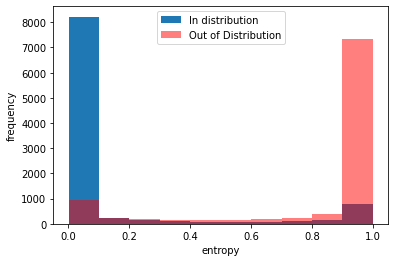

OOD accepted with avg ID entropy threshold of  0.12536794 :  1026 out of  9984
ID accepted with avg ID entropy threshold of  0.12536794 :  8298 out of  9984 with acc of  0.9998794890335021
overall acc on ID: 0.9864783653846154


In [22]:
def buildOutlierPlot(ID,OOD,threshold):
    _ = plt.hist(ID['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
    print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
    Correct = ID.loc[(ID['correct'] == True)]
    Incorrect = ID.loc[(ID['correct'] == False)]
    print("overall acc on ID:",len(Correct)/len(ID))
    
buildOutlierPlot(outputs, outputsKmnist,  0.12536794)

In [23]:
def entropyMetric_old():
    def entropy(p, y_hat):
        #METRIC OF THE mean of uncertainity
        y_hat = tf.nn.softmax(y_hat)
        val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        return sumEntropies
    return entropy

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model = keras.models.load_model("./models/mnist_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy',entropyMetric_old()])

history = model.fit(train_ds, epochs=10)

Epoch 1/10
1718/1718 [==============================] - 7s 4ms/step - loss: 0.5652 - accuracy: 0.9016 - entropy: -1593.3798
Epoch 2/10
1718/1718 [==============================] - 7s 4ms/step - loss: 0.1267 - accuracy: 0.9614 - entropy: -1700.8729
Epoch 3/10
1718/1718 [==============================] - 7s 4ms/step - loss: 0.1079 - accuracy: 0.9678 - entropy: -1747.2897
Epoch 4/10
1718/1718 [==============================] - 7s 4ms/step - loss: 0.0967 - accuracy: 0.9712 - entropy: -1656.2780
Epoch 5/10
1718/1718 [==============================] - 7s 4ms/step - loss: 0.0862 - accuracy: 0.9738 - entropy: -1657.4523
Epoch 6/10
1718/1718 [==============================] - 7s 4ms/step - loss: 0.0855 - accuracy: 0.9741 - entropy: -1688.6460
Epoch 7/10
1718/1718 [==============================] - 7s 4ms/step - loss: 0.0757 - accuracy: 0.9770 - entropy: -1651.6333
Epoch 8/10
1718/1718 [==============================] - 7s 4ms/step - loss: 0.0757 - accuracy: 0.9775 - entropy: -1678.0394
Epoch 9/

In [24]:
import math
num_classes=10
def getPredictionsEntropy(model, input_set):
    stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    pAcc=[]
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            y_hat =tf.nn.softmax(prediction)
            val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
            u =  -tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    _uncert = np.array(Uncert)
    print(_uncert)
    print("avg entropy",_uncert.mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df


In [25]:

outputs = getPredictionsEntropy(model,test_ds)
print(outputs)

[5.1389320e-04 4.2224823e-08 1.0804759e-02 ... 1.1194019e-02 4.9162450e-01
 5.9113181e-06]
avg entropy 0.03597876
      x  y        uncert correct
0     7  7  5.138932e-04       1
1     2  2  4.222482e-08       1
2     1  1  1.080476e-02       1
3     0  0  8.083344e-04       1
4     4  4  5.289416e-05       1
...  .. ..           ...     ...
9979  7  7  1.041894e-03       1
9980  2  2  1.664347e-04       1
9981  6  6  1.119402e-02       1
9982  5  5  4.916245e-01       1
9983  0  0  5.911318e-06       1

[9984 rows x 4 columns]


In [26]:

outputsKmnist= getPredictions(model,test_ds_kmnist)
print(outputsKmnist)

[0.59854066 0.68870974 0.6438995  ... 0.607276   0.66225594 0.6450849 ]
avg entropy 0.64248604
      x  y    uncert correct
0     4  2  0.598541       0
1     7  9  0.688710       0
2     0  3  0.643900       0
3     2  8  0.704571       0
4     5  3  0.648086       0
...  .. ..       ...     ...
9979  2  1  0.624548       0
9980  0  5  0.596575       0
9981  3  3  0.607276       1
9982  4  1  0.662256       0
9983  4  3  0.645085       0

[9984 rows x 4 columns]


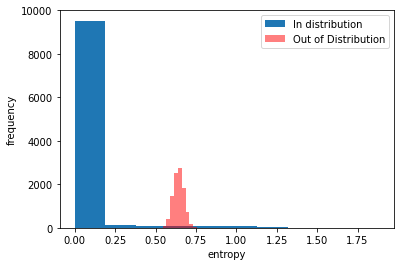

OOD accepted with avg ID entropy threshold of  0.03597876 :  0 out of  9984
ID accepted with avg ID entropy threshold of  0.03597876 :  9048 out of  9984 with acc of  0.9991158267020336
overall acc on ID: 0.9867788461538461


In [28]:
buildOutlierPlot(outputs, outputsKmnist,  0.03597876)

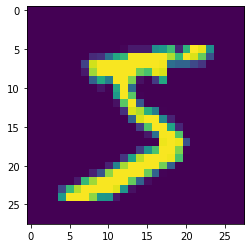

[[-144.11493  -201.12714  -148.4199    -19.680092 -200.32196   153.65378
  -149.62079  -151.23996   -58.615086  -85.02543 ]]
label 5 : 5 uncert 0.00045379027 beliefMax 0.99958503


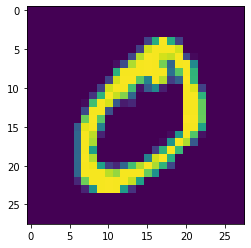

[[ 160.87216  -211.84529   -27.140783  -82.868645 -131.27397   -79.401024
   -24.818735 -159.5492    -11.22631   -24.387835]]
label 0 : 0 uncert 0.0004537817 beliefMax 0.9995661


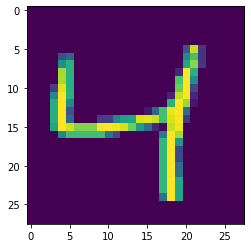

[[-267.58942   -50.759575  -96.63352  -143.49808   142.98776  -126.77123
  -218.32515   -50.205032  -76.1528    -24.528885]]
label 4 : 4 uncert 0.00045379123 beliefMax 0.9995872


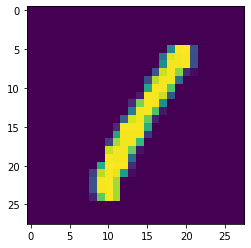

[[ -41.80345    123.24728    -42.519543  -145.05109    -12.951641
   -72.89272    -48.10712    -31.310404     4.3126135  -50.1693   ]]
label 1 : 1 uncert 0.00045375412 beliefMax 0.9995054


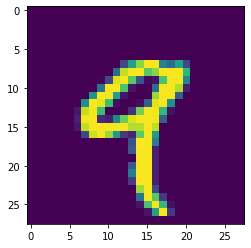

[[-170.41699   -154.53998   -119.616714   -86.33174    -20.018162
  -100.81129   -217.29033    -25.730824    -3.0403218  149.93341  ]]
label 9 : 9 uncert 0.0004537737 beliefMax 0.99954855


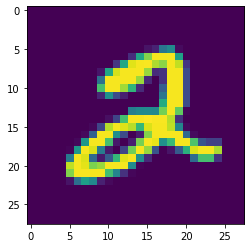

[[-149.9561  -149.07133  186.78662  -39.14069  -94.55419 -143.48148
  -166.63795 -136.39598  -67.49109 -109.14744]]
label 2 : 2 uncert 0.0004537928 beliefMax 0.99959064


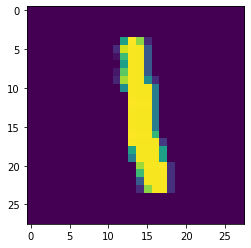

[[-83.40699   146.86758   -59.06645   -23.150196  -21.293926  -63.817665
  -81.65619   -32.387085   -1.6964554 -66.90261  ]]
label 1 : 1 uncert 0.00045377045 beliefMax 0.99954134


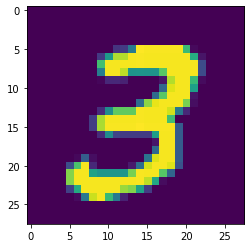

[[-196.27231  -165.91249   -38.547604  141.68686  -233.38159   -66.56121
  -274.9203    -92.34207   -78.260506  -42.126656]]
label 3 : 3 uncert 0.00045379245 beliefMax 0.9995898


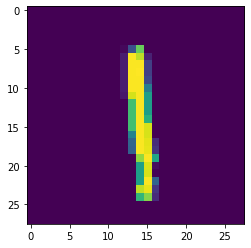

[[-84.46834    135.14761    -67.87383    -50.1726      12.600965
  -40.772392   -59.49407    -39.26364      0.86571753 -60.955692  ]]
label 1 : 1 uncert 0.00045369723 beliefMax 0.99938005


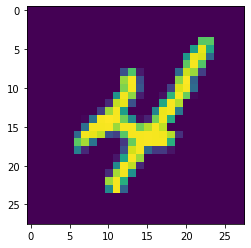

[[-129.08438   -50.447693  -53.41506   -94.360306  188.15097   -95.155205
  -108.341354  -60.34502   -37.7856   -107.13466 ]]
label 4 : 4 uncert 0.00045379248 beliefMax 0.9995899


In [53]:
# test_img = tf.image.rgb_to_grayscale(test_img, name=None)
# pred = model.predict(tf.reshape(test_img,(1,32,32)))
# print(pred, tf.nn.softplus(pred))
# rotateImg(model,test_img, exp_evidence)
# 324.33612 -195.3844  -328.90497 -348.173   -302.2171  -291.78085  -418.81058 -277.24625 -335.44376 -236.58258
# 2278.2148 -3066.1064 -3517.2793 -3051.9978 -2099.7322 -2623.3499  -2526.0488 -3102.543  -2939.1077 -3429.5134
num_classes = 10 
for i in range(10):    
    kmnist_digit = x_train[i]
    # kmnist_digit = tf.image.rgb_to_grayscale(kmnist_digit, name=None)
    kmnist_label = y_train[i]
    plt.imshow(kmnist_digit)
    plt.show()
    _pred=model.predict(tf.reshape(kmnist_digit,(1,28,28)))
    evidence =exp_evidence(_pred)
    alpha = evidence +1
    # alpha = exp_evidence(logits)
    S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
    E = alpha - 1
    
    Mass = alpha / S
    # A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
    u = num_classes / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
    print(_pred)
    print("label", np.argmax(_pred),":",np.argmax(kmnist_label), "uncert", u.numpy().mean(), "beliefMax", np.amax(Mass).mean() )
    

In [63]:
from scipy.special import gammaln, digamma
def dirichlet_prior_network_uncertainty(logits, epsilon=1e-10, alpha_correction=True):
    """
    :param logits:
    :param epsilon:
    :return:
    """

    logits = np.asarray(logits, dtype=np.float64)
    alphas = np.exp(logits)

    alphas = np.clip(alphas, 0, np.finfo(np.dtype("float32")).max)

    if alpha_correction:
        alphas = alphas + 1

    alpha0 = np.sum(alphas, axis=1, keepdims=True)
    probs = alphas / alpha0

    conf = np.max(probs, axis=1)

    entropy_of_exp = -np.sum(probs * np.log(probs + epsilon), axis=1)
    expected_entropy = -np.sum(
        (alphas / alpha0) * (digamma(alphas + 1) - digamma(alpha0 + 1.0)), axis=1
    )

    mutual_info = entropy_of_exp - expected_entropy

    epkl = np.squeeze((alphas.shape[1] - 1.0) / alpha0)

    dentropy = (
        np.sum(
            gammaln(alphas) - (alphas - 1.0) * (tf.compat.v1.digamma(alphas) - tf.compat.v1.digamma(alpha0)),
            axis=1,
            keepdims=True,
        )
        - gammaln(alpha0)
    )

    uncertainty = {
        "confidence_alea_uncert.": conf,
        "entropy_of_expected": -entropy_of_exp,
        "expected_entropy": -expected_entropy,
        "mutual_information": -mutual_info,
        "EPKL": -epkl,
        "differential_entropy": -np.squeeze(dentropy),
    }

    # return {k: torch.from_numpy(v).float() for k, v in uncertainty.items()}
    return uncertainty

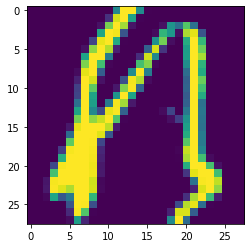

[[   3.6547885  -88.552124   -64.8676    -202.13365     51.108673
   -93.26668    -57.08335   -114.90172    -38.33988    -21.019964 ]]
label 4 : 8 uncert 0.05636841 beliefMax 0.94030476


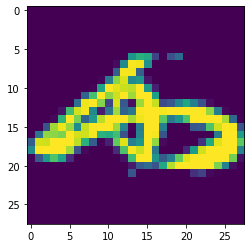

[[-102.43099  -107.33582    18.868673 -132.56458    49.587833  -12.620293
    14.08139  -123.27861   -50.201324 -144.15533 ]]
label 4 : 7 uncert 0.06120052 beliefMax 0.87774026


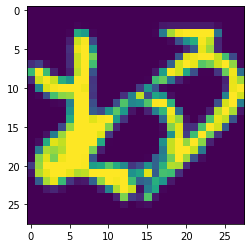

[[ -19.116898 -131.57118   -88.65529   -84.2956    -22.319008   13.676836
    18.163992 -170.73624   -47.44192  -246.00053 ]]
label 6 : 0 uncert 0.4916355 beliefMax 0.3515034


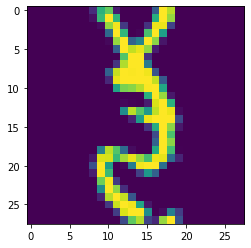

[[-112.95905    -49.270134    15.104291    31.862564  -148.16475
     4.6684823 -114.7202    -106.082436   -88.793335   -80.198654 ]]
label 3 : 1 uncert 0.24795927 beliefMax 0.6247996


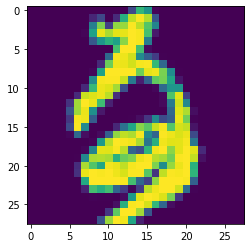

[[ -23.311604  -170.52377     16.856684    -2.7530332 -153.19713
   -34.01878    -94.93455    -89.46259    -42.943756   -47.314957 ]]
label 2 : 4 uncert 0.6131717 beliefMax 0.39218807


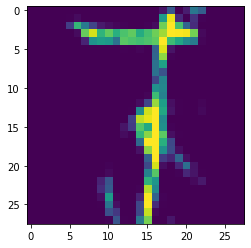

[[ -96.17724    -18.897186   -66.49815    -64.8811     -46.85566
   -64.01913   -101.109924    -0.8327546  -82.81389    -60.659996 ]]
label 7 : 2 uncert 0.9019085 beliefMax 0.17317525


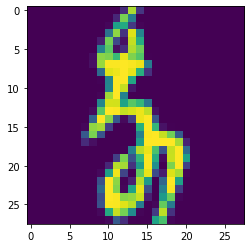

[[-203.96024    -59.045338   -17.634884   -26.463572   -40.92103
     1.2431417  -44.89428    -64.11339    -14.958236  -151.4419   ]]
label 5 : 4 uncert 0.85975784 beliefMax 0.18333231


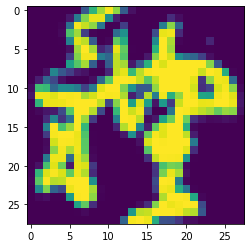

[[ -73.51096  -125.78233   -38.619545  -67.03466   -35.7213   -114.47669
  -131.55943   -15.855171  -14.841111  -89.35246 ]]
label 8 : 8 uncert 0.95394313 beliefMax 0.11702056


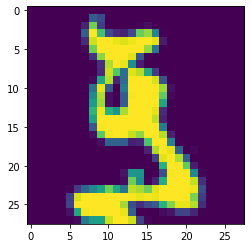

[[-256.02536   -120.707954  -149.88954      8.217907   -45.61068
    51.853363  -175.32773   -176.6638     -80.43709     -6.8867545]]
label 5 : 1 uncert 0.052240793 beliefMax 0.9384195


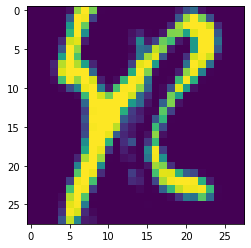

[[ -87.21249   -24.989677  -14.948182 -158.48967    11.545985 -131.57298
   -28.140997  -40.99341    24.136114 -152.14445 ]]
label 8 : 1 uncert 0.40436238 beliefMax 0.49228057


In [48]:
# test_img = tf.image.rgb_to_grayscale(test_img, name=None)
# pred = model.predict(tf.reshape(test_img,(1,32,32)))
# print(pred, tf.nn.softplus(pred))
# rotateImg(model,test_img, exp_evidence)
# 324.33612 -195.3844  -328.90497 -348.173   -302.2171  -291.78085  -418.81058 -277.24625 -335.44376 -236.58258
# 2278.2148 -3066.1064 -3517.2793 -3051.9978 -2099.7322 -2623.3499  -2526.0488 -3102.543  -2939.1077 -3429.5134
num_classes = 10 
for i in range(10):    
    kmnist_digit = kmnist_train_images[i]
    # kmnist_digit = tf.image.rgb_to_grayscale(kmnist_digit, name=None)
    kmnist_label = kmnist_train_labels[i]
    plt.imshow(kmnist_digit)
    plt.show()
    _pred=model.predict(tf.reshape(kmnist_digit,(1,28,28)))
    evidence =exp_evidence(_pred)
    alpha = evidence +1
    # alpha = exp_evidence(logits)
    S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
    E = alpha - 1
    
    Mass = alpha / S
    # A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
    u = num_classes / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
    print(_pred)
    print("label", np.argmax(_pred),":",np.argmax(kmnist_label), "uncert", u.numpy().mean(), "beliefMax", np.amax(Mass).mean() )
    

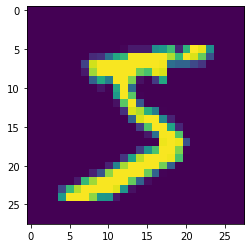

label 5 uncert [[0.00045381]]


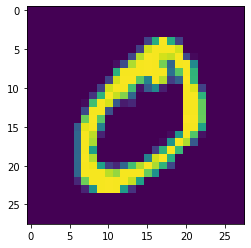

label 0 uncert [[0.00045396]]


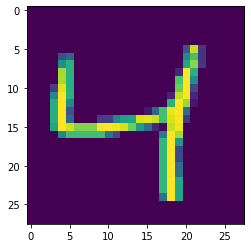

label 4 uncert [[0.00045398]]


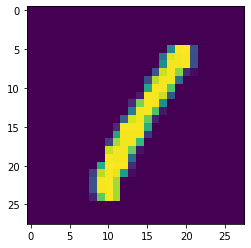

label 1 uncert [[0.00045399]]


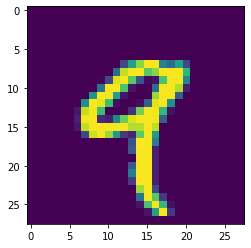

label 9 uncert [[0.00045357]]


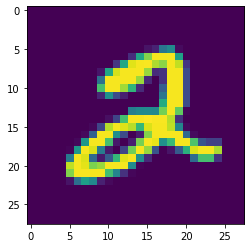

label 2 uncert [[0.000454]]


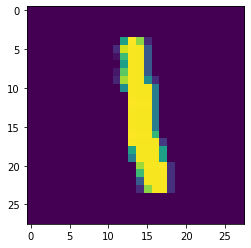

label 1 uncert [[0.00045391]]


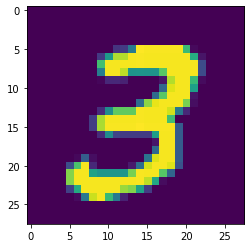

label 3 uncert [[0.00045398]]


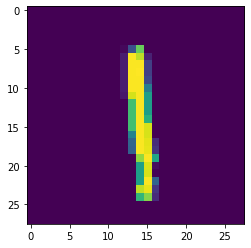

label 1 uncert [[0.00045377]]


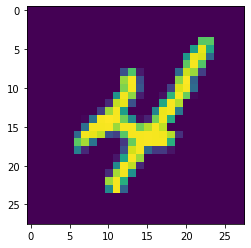

label 4 uncert [[0.00045399]]


In [44]:
for i in range(10):    
    kmnist_digit = x_train[i]
    kmnist_label = y_train[i]
    plt.imshow(kmnist_digit)
    plt.show()
    _pred=model.predict(tf.reshape(kmnist_digit,(1,28,28)))
    evidence =exp_evidence(_pred)
    alpha = evidence 
    # alpha = exp_evidence(logits)
    S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
    E = alpha - 1
    # A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    u = num_classes / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
    print("label", np.argmax(kmnist_label), "uncert", u.numpy())

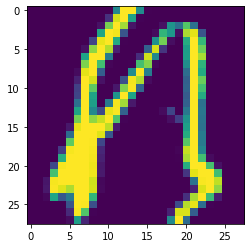

pred tf.Tensor([[nan nan nan nan nan nan nan nan nan nan]], shape=(1, 10), dtype=float32) label? 0 uncert tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
pred tf.Tensor([[nan nan nan nan nan nan nan nan nan nan]], shape=(1, 10), dtype=float32) label? 0 uncert tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
pred tf.Tensor([[nan nan nan nan nan nan nan nan nan nan]], shape=(1, 10), dtype=float32) label? 0 uncert tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
pred tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32) label? 0 uncert tf.Tensor([[2.3116196e+32]], shape=(1, 1), dtype=float32)
pred tf.Tensor([[nan nan nan nan nan nan nan nan nan nan]], shape=(1, 10), dtype=float32) label? 0 uncert tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
pred tf.Tensor([[nan nan nan nan nan nan nan nan nan nan]], shape=(1, 10), dtype=float32) label? 0 uncert tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
pred tf.Tensor([[nan nan nan nan nan nan nan nan nan nan]], shape=(1, 10), d

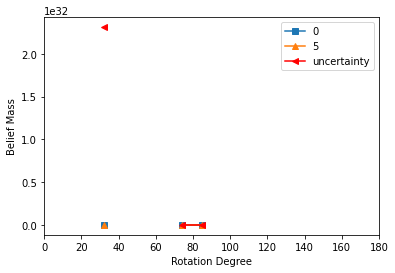

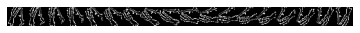

[inf,
 inf,
 inf,
 2.3116196e+32,
 inf,
 inf,
 inf,
 0.028277604,
 0.022873158,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

In [30]:
# digit_one = x_train[5]
plt.imshow(kmnist_digit)
plt.show()
rotateImg(model,kmnist_digit, tf.nn.softplus, verbose=False)

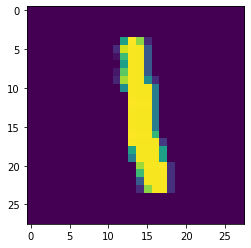

[[-1698.349     892.89044  -470.2386   -281.09958  -582.8109  -1212.5355
   -715.2916   -665.18134  -386.67035 -1358.982  ]] tf.Tensor(
[[  0.      892.89044   0.        0.        0.        0.        0.
    0.        0.        0.     ]], shape=(1, 10), dtype=float32) label 1
[[-2056.802     542.335    -535.6529   -307.7063   -347.12006 -1237.0326
   -945.92377  -812.90704  -423.10318 -1505.6388 ]] tf.Tensor(
[[  0.    542.335   0.      0.      0.      0.      0.      0.      0.
    0.   ]], shape=(1, 10), dtype=float32) label 1
[[-2163.6648   -336.45544  -528.4765   -343.0739   -503.91718  -927.845
  -1140.7765   -953.3809   -428.09738 -1793.077  ]] tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32) label 1
[[-2140.1733   -959.5615   -487.25763  -371.1513   -346.5259   -913.5925
  -1093.4277   -966.02216  -392.836   -1795.6602 ]] tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32) label 4
[[-2280.0002  -1885.1719   -486.5452   -427.93695  

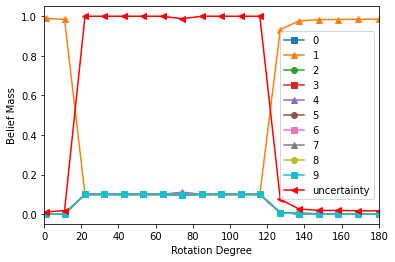

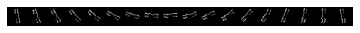

[0.01107554,
 0.018104954,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9874748,
 1.0,
 1.0,
 1.0,
 1.0,
 0.07489156,
 0.026235579,
 0.018763153,
 0.018492255,
 0.017089864,
 0.016361937]

In [19]:
digit_one = x_train[6]
plt.imshow(digit_one)
plt.show()
rotateImg(model,digit_one, True)

In [11]:

#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=(227,227,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function


def metric_wrapper(annealing_coef):
    def detailed_losses(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (tf.reduce_sum(A+B), tf.reduce_sum(C)) # Note the `axis=-1`
    return detailed_losses

# #example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
# for i in range(4):
#     print("annealing_coef:", tf.minimum(1,tf.cast(i/10,tf.float32)))
#     # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
#     model.compile(loss=loss_wrapper(0), optimizer="adam", metrics=["accuracy", detailed_losses])
#     model.fit(train_ds,epochs = 1)
    

In [39]:
# model = keras.Sequential(
#     [
#         keras.Input(shape=(28,28,1)),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes),
#     ]
# )
# model.save("./models/mnist_blank.hdf5")

In [11]:

#entropy version



def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        # tf.print(tf.reduce_sum(A+B), tf.reduce_sum(C))
        
        return (A + B) + C
    return custom_loss_function

def lossMetric(annealing_coef):
    def lossMetric(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (tf.reduce_mean(A+B)) # Note the `axis=-1`
    return lossMetric

def klMetric(annealing_coef):
    def klMetric(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        # tf.print(logits)
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (tf.reduce_mean(C)) # Note the `axis=-1`
    return klMetric

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))


def loss_EDL(annealing):
    def loss_func(p, logits): 
        func=tf.compat.v1.digamma
        E = exp_evidence(logits)
        alpha = E + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        # E = alpha - 1
    
        A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
        # annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))
    
        alp = E*(1-p) + 1 
        B =  annealing * KL(alp,10)
    
        return (A + B)
    return loss_func

def evidence_crossentropy(annealing_rate=1, momentum=1, decay=1, global_loss=False,num_outputs=10):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = tf.nn.softplus(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print("A+B",(A+B).shape, tf.reduce_sum(A+B, axis=1))
        # annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_rate * KL(alp,num_outputs)
        # print("c",C)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        # tf.print("loss",loss.shape,loss)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

model = tf.keras.models.load_model("./models/mnist_blank.hdf5")
#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(10):
    # if i > 5:
    # annealing = tf.minimum(1,tf.cast((i+1)/100,tf.float32))
    annealing = 0
    # else:
        # annealing = 0
    print("annealing_coef:", annealing)
    # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.compile(loss=loss_EDL(annealing), optimizer="adam", metrics=["accuracy",lossMetric(annealing),klMetric(annealing)])
    model.fit(train_ds,epochs = 1)
    
    

annealing_coef: 0
1718/1718 [==============================] - 8s 4ms/step - loss: 0.2004 - accuracy: 0.9414 - lossMetric: 0.2548 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 7s 4ms/step - loss: 0.0824 - accuracy: 0.9764 - lossMetric: 0.1306 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 7s 4ms/step - loss: 0.0659 - accuracy: 0.9810 - lossMetric: 0.1019 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 7s 4ms/step - loss: 0.0599 - accuracy: 0.9827 - lossMetric: 0.0872 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 7s 4ms/step - loss: 0.0542 - accuracy: 0.9847 - lossMetric: 0.0769 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 7s 4ms/step - loss: 0.0505 - accuracy: 0.9860 - lossMetric: 0.0677 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 7s 4ms/step - loss:

In [44]:
model = tf.keras.models.load_model("./models/mnist_blank.hdf5")
#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(10):
    # if i > 5:
    # annealing = tf.minimum(1,tf.cast((i+1)/100,tf.float32))
    annealing = 0
    # else:
        # annealing = 0
    print("annealing_coef:", annealing)
    # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.compile(loss=loss_wrapper(annealing), optimizer="adam", metrics=["accuracy",lossMetric(annealing),klMetric(annealing)])
    model.fit(train_ds,epochs = 1)

annealing_coef: 0
1718/1718 [==============================] - 8s 4ms/step - loss: 0.1137 - accuracy: 0.9334 - lossMetric: 0.1137 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 8s 4ms/step - loss: 0.0559 - accuracy: 0.9704 - lossMetric: 0.0559 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 8s 4ms/step - loss: 0.0461 - accuracy: 0.9753 - lossMetric: 0.0461 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 8s 4ms/step - loss: 0.0431 - accuracy: 0.9781 - lossMetric: 0.0431 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 8s 4ms/step - loss: 0.0425 - accuracy: 0.9778 - lossMetric: 0.0425 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 8s 4ms/step - loss: 0.0400 - accuracy: 0.9800 - lossMetric: 0.0400 - klMetric: 0.0000e+00
annealing_coef: 0
1718/1718 [==============================] - 7s 4ms/step - loss:

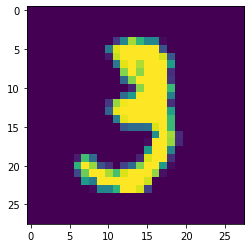

[[-2394.259  -1445.9475 -2052.994   1886.7806 -3303.918  -1090.5
  -6027.716  -3077.8188 -2748.5422 -1292.1572]] tf.Tensor(
[[   0.        0.        0.     1886.7806    0.        0.        0.
     0.        0.        0.    ]], shape=(1, 10), dtype=float32)
[[-2081.699  -1368.8474 -2228.3645  1850.9685 -3072.1243 -1161.9066
  -5546.369  -2778.3176 -3131.076  -1284.0542]] tf.Tensor(
[[   0.        0.        0.     1850.9685    0.        0.        0.
     0.        0.        0.    ]], shape=(1, 10), dtype=float32)
[[-2635.172  -1526.3801 -2937.9446  2199.7593 -2901.053   -961.5335
  -5381.8633 -2973.9473 -3505.4824 -1088.272 ]] tf.Tensor(
[[   0.        0.        0.     2199.7593    0.        0.        0.
     0.        0.        0.    ]], shape=(1, 10), dtype=float32)
[[-2631.3887  -2147.4119  -2476.7292   1274.9385  -2690.391    -579.59393
  -4660.067   -1936.5409  -2598.2656   -881.3771 ]] tf.Tensor(
[[   0.        0.        0.     1274.9385    0.        0.        0.
     0.        0. 

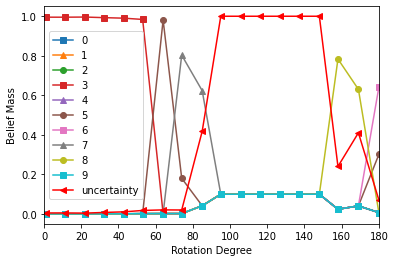

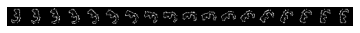

[0.005272091,
 0.005373546,
 0.0045253797,
 0.0077824737,
 0.010934063,
 0.01797566,
 0.020788904,
 0.020239027,
 0.4179893,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.24034944,
 0.41063556,
 0.07102581]

In [68]:
# pred = model.predict(tf.reshape(digit_one,(1,28,28)))
# print(pred, tf.nn.softplus(pred))
digit_one = x_train[10]
plt.imshow(digit_one)
plt.show()
rotateImg(model,digit_one)

In [55]:
print(tf.nn.softplus(-50.0))

tf.Tensor(1.9287499e-22, shape=(), dtype=float32)


[[-647.7345   696.4308  -979.0093  -722.8716  -793.7095  -830.4821
  -726.825   -666.07495 -361.5338  -563.43036]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


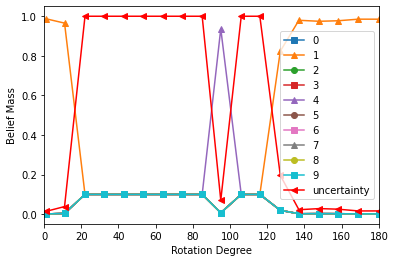

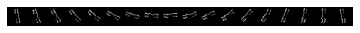

[0.014155668,
 0.038520016,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.07063323,
 1.0,
 1.0,
 0.19625838,
 0.022649346,
 0.02831071,
 0.02538067,
 0.016398367,
 0.01655108]

In [43]:
print((model.predict(tf.reshape(digit_one,(1,28,28)))))
rotateImg(model)

In [67]:
def rotateImg(model, digit_one):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        print(_pred, tf.nn.softplus(_pred))
        evidence = tf.nn.softplus(_pred)
        alpha = evidence + 1
        u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        # print("prob", evidence)
        # print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        # print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)

    print(labels)
    for j in range(len(labels)):
        plt.plot(ldeg,lp[:,j],marker=marker[j])
    labels += ['uncertainty']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass')
    # plt.yscale("log")
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    return(uncert)

In [31]:
def rotateImg(model,digit_one, verbose=False):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        evidence = tf.nn.softplus(_pred)
        alpha = evidence + 1
        u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        # print("prob", evidence)
        # print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        # print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)

    print(labels)
    for j in range(len(labels)):
        plt.plot(ldeg,lp[:,j],marker=marker[j])
    labels += ['uncertainty']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass')
    # plt.yscale("log")
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    return(uncert)

In [ ]:
model.evaluate(test_ds)

In [16]:

#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function



#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(4):
    print("annealing_coef:", tf.minimum(1,tf.cast(i/10,tf.float32)))
    annealing = tf.minimum(1,tf.cast(i/10,tf.float32))
    model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    # model.compile(loss=evidence_crossentropy(annealing), optimizer="adam", metrics=["accuracy"])
    model.fit(train_ds,epochs = 1)
    

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1718/1718 [==============================] - 10s 5ms/step - loss: 0.1313 - accuracy: 0.9218
annealing_coef: tf.Tensor(0.1, shape=(), dtype=float32)
1718/1718 [==============================] - 9s 5ms/step - loss: 0.1344 - accuracy: 0.9647
annealing_coef: tf.Tensor(0.2, shape=(), dtype=float32)
1718/1718 [==============================] - 9s 4ms/step - loss: 0.1482 - accuracy: 0.9674
annealing_coef: tf.Tensor(0.3, shape=(), dtype=float32)
1718/1718 [==============================] - 11s 6ms/step - loss: 0.1608 - accuracy: 0.9695


1


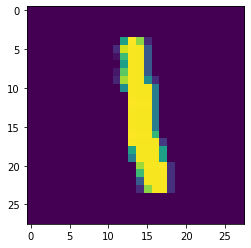

In [123]:
import matplotlib.pyplot as plt
digit_one = x_train[6]

print(np.argmax(model.predict(digit_one.reshape(1,28,28))))
plt.imshow(digit_one.reshape(28,28)) 
plt.show()

In [135]:
def rotate_img_crossevidence(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
    #     print(_pred)
        # evidence = tf.nn.relu(_pred)
        evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1


        # evidence = tf.nn.relu(_pred)
        # alpha = evidence + 1

        u = tf.reduce_sum(evidence, axis=1, keepdims=True) #uncertainty

        # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        print("prob", evidence)
        print("u", u.numpy(), "prob",tf.reduce_sum(evidence).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += evidence.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(evidence[0])
        print(u.numpy())
        pred.append(pred)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels",labels)
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    for j in range(len(labels)):
        print(labels[j])
        print(lp)
        y =[]
        for i in range(len(lp)):
            y.append(lp[i][j])


        plt.plot(ldeg,y,marker=marker[j])



    labels += ['Entropy']
    plt.plot(ldeg,uncert,marker='<',ls='--',c='red',zorder=0)

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Predicted Probability')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

prob tf.Tensor(
[[6.5535186e-13 1.8844068e-01 2.7934789e-07 1.1621394e-08 5.5195746e-09
  2.8452870e-11 4.5765403e-10 7.9887830e-09 5.2179043e-06 1.9766713e-10]], shape=(1, 10), dtype=float32)
u [[0.18844621]] prob 0.18844621
[[0.18844621]]
prob tf.Tensor(
[[3.61930054e-24 5.23236622e-07 1.17731085e-11 3.07065673e-14
  5.92468445e-18 6.72315817e-18 3.69096184e-19 2.82275813e-14
  1.58854082e-12 8.14536661e-17]], shape=(1, 10), dtype=float32)
u [[5.2325004e-07]] prob 5.2325004e-07
[[5.2325004e-07]]
prob tf.Tensor(
[[1.0103113e-21 6.2338011e-05 2.7430216e-11 2.7323128e-14 1.9854088e-16
  1.5509566e-14 1.6467396e-17 5.1948827e-16 7.6999594e-13 1.6310468e-18]], shape=(1, 10), dtype=float32)
u [[6.233804e-05]] prob 6.233804e-05
[[6.233804e-05]]
prob tf.Tensor(
[[1.66884962e-15 1.13744164e-07 3.11397501e-12 1.51806831e-11
  7.54755850e-13 8.48355674e-12 1.99233008e-14 5.89834171e-12
  5.62279390e-13 5.99075434e-17]], shape=(1, 10), dtype=float32)
u [[1.1377818e-07]] prob 1.1377818e-07
[[1.13

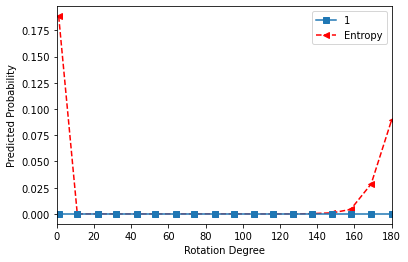

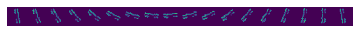

[0.18844621, 5.2325004e-07, 6.233804e-05, 1.1377818e-07, 9.085725e-11, 1.1687073e-08, 5.7493697e-05, 2.9753628e-05, 9.05475e-05, 7.244954e-05, 7.7653635e-09, 1.6452828e-10, 3.8197495e-06, 0.00027558542, 0.0010198655, 0.004291958, 0.028569005, 0.08956691]


In [136]:
rotate_img_crossevidence(model)

prob tf.Tensor(
[[6.5535186e-13 1.8844068e-01 2.7934789e-07 1.1621394e-08 5.5195746e-09
  2.8452870e-11 4.5765403e-10 7.9887830e-09 5.2179043e-06 1.9766713e-10]], shape=(1, 10), dtype=float32)
u [[0.98150396]] prob 1.0
[[0.98150396]]
prob tf.Tensor(
[[3.61930054e-24 5.23236622e-07 1.17731085e-11 3.07065673e-14
  5.92468445e-18 6.72315817e-18 3.69096184e-19 2.82275813e-14
  1.58854082e-12 8.14536661e-17]], shape=(1, 10), dtype=float32)
u [[1.]] prob 1.0000001
[[1.]]
prob tf.Tensor(
[[1.0103113e-21 6.2338011e-05 2.7430216e-11 2.7323128e-14 1.9854088e-16
  1.5509566e-14 1.6467396e-17 5.1948827e-16 7.6999594e-13 1.6310468e-18]], shape=(1, 10), dtype=float32)
u [[0.9999937]] prob 0.9999999
[[0.9999937]]
prob tf.Tensor(
[[1.66884962e-15 1.13744164e-07 3.11397501e-12 1.51806831e-11
  7.54755850e-13 8.48355674e-12 1.99233008e-14 5.89834171e-12
  5.62279390e-13 5.99075434e-17]], shape=(1, 10), dtype=float32)
u [[1.]] prob 1.0000001
[[1.]]
prob tf.Tensor(
[[2.2831786e-16 5.1840771e-11 3.6141695e

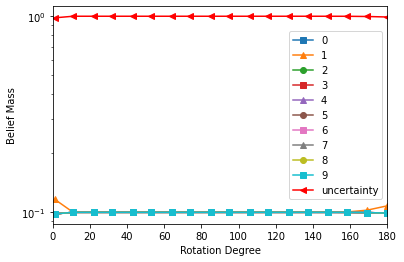

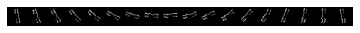

[0.98150396, 1.0, 0.9999937, 1.0, 1.0, 1.0, 0.9999943, 0.999997, 0.99999094, 0.9999927, 1.0, 1.0, 0.99999964, 0.99997246, 0.9998981, 0.999571, 0.9971512, 0.9911228]


In [124]:
import tensorflow_addons as tfa
linspace = np.linspace(1,180,num=18)
digit_one = x_train[6]
import matplotlib.pyplot as plt
Mdeg = 180 
Ndeg = int(Mdeg/10)+1
K = 10
# print(linspace)
pred = []
uncert = []
label = []
answer = []
ldeg = []
lp = []
lu=[]
scores = np.zeros((1,K))
threshold = 0.001
Results = pd.DataFrame()
rimgs = []
K=10
from PIL import Image

for i in linspace:
    i = int(i)
    radians = i* np.pi/180
    # print(radians)
    rotate = tfa.image.rotate(digit_one, tf.constant(radians))
    rimg = rotate
    rimgs.append(rimg.numpy().reshape(28,28))
#     rimgs.append(rotate)
    _pred=model.predict(tf.reshape(rotate,(1,28,28)))
#     print(_pred)
    # evidence = tf.nn.relu(_pred)
    evidence = tf.nn.softplus(_pred)
    # alpha = evidence + 1
    
    
    # evidence = tf.nn.relu(_pred)
    alpha = evidence + 1

    u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty

    prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
    print("prob", evidence)
    print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
    # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
    # prob = evidence/tf.reduce_sum(evidence, 1) 
#     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
    scores += prob.numpy().astype("float") >= threshold
#     print("scores",scores)
    lp.append(prob[0])
    print(u.numpy())
    pred.append(prob)
    uncert.append(u.numpy().mean())
    label.append(1)
    answer.append(np.argmax(_pred))
    ldeg.append(i)
labels = np.arange(10)[scores[0].astype(bool)]
# print("labels",labels)
lp = np.array(lp)[:,labels]
# c = ['black','blue','red','brown','purple','cyan']
marker = ['s','^','o']*4
labels = labels.tolist()
# print("lp",lp)

print(labels)
for j in range(len(labels)):
    # print(lp[:,j], answer[j])
    
    
    plt.plot(ldeg,lp[:,j],marker=marker[j])
    


labels += ['uncertainty']
plt.plot(ldeg,uncert,marker='<',c='red')

plt.legend(labels)
 
plt.xlim([0,Mdeg])  
plt.xlabel('Rotation Degree')
plt.ylabel('Belief Mass')
plt.yscale("log")
plt.show()

img = Image.new('L', (28*len(rimgs), 28))
x_offset =0
for im in rimgs:
#     print(im)
    _im = Image.fromarray(np.uint8((im)*255))
    img.paste(_im,(x_offset,0))
    x_offset += _im.size[0]
    
plt.figure(figsize=[6.2,100])
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()
#     print(pred, np.argmax(pred))
#     _ = plt.imshow(rotate)
#     plt.show()
print(uncert)

In [102]:
def rotate_img_entropy():
    def calcEntropy_Tensors2(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #doesn't deal with cases of log(0)
        val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        return -sumEntropies

    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.2
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        prob = _pred
        # evidence = tf.nn.relu(_pred)
        # evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1
        
        u = calcEntropy_Tensors2(prob)
        print("prob", _pred)
        print("u", tf.reduce_sum(u).numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += _pred.astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    print(labels)
    for j in range(len(labels)):
        print(lp[:,j], answer[j])


        plt.plot(ldeg,lp[:,j],marker=marker[j])



    labels += ['Entropy']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass / Entropy Score')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

In [161]:
def rotate_img_crossentropy(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.2
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        # evidence = tf.nn.relu(_pred)
        evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1
        prob = np.amax(evidence)
        # u = prob
        u = tf.reduce_sum(evidence, axis=1, keepdims=True).numpy() #uncertainty
        # u = np.reduce_sum(evidence)
        print("prob", evidence)
        print("u", tf.reduce_sum(u).numpy(), "prob",tf.reduce_sum(evidence).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.astype("float") 
    #     print("scores",scores)
    
    
    
        lp.append(evidence[0])
        pred.append(prob)
        uncert.append(u.mean())
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels",labels)
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    plt.yscale('log')
    
    for j in range(len(labels)):
        print(labels[j])
        # print(lp)
        y =[]
        for i in range(len(lp)):
            y.append(lp[i][j])


        plt.plot(ldeg,y,marker=marker[j])



    labels += ['Certanity']
    plt.plot(ldeg,uncert,marker='<',ls='--',c='red',zorder=0)

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Predicted Probability')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

prob tf.Tensor(
[[1.0964890e-08 1.6847100e+00 1.8928564e-06 1.7925127e-07 1.0670565e-05
  1.3333648e-07 1.7490745e-06 7.6637001e-08 4.9270166e-05 8.1341007e-08]], shape=(1, 10), dtype=float32)
u 1.684774 prob 1.684774
prob tf.Tensor(
[[1.7824584e-11 1.1883412e-01 1.5200213e-05 1.5144473e-06 4.2996984e-09
  1.9316868e-08 1.9449025e-09 4.2931267e-09 2.6531627e-05 3.0361946e-08]], shape=(1, 10), dtype=float32)
u 0.118877426 prob 0.118877426
prob tf.Tensor(
[[1.36075247e-13 1.04371775e-02 9.44117801e-06 4.49078152e-09
  3.29475256e-08 6.18469675e-09 1.22163451e-11 2.27892749e-09
  3.26600897e-08 1.74050375e-11]], shape=(1, 10), dtype=float32)
u 0.010446697 prob 0.010446697
prob tf.Tensor(
[[4.16907963e-13 2.50979941e-02 1.35669552e-06 1.01298845e-08
  2.57853173e-07 1.42367573e-09 3.64997637e-13 1.56718940e-07
  1.30392586e-10 1.41429099e-11]], shape=(1, 10), dtype=float32)
u 0.025099777 prob 0.025099777
prob tf.Tensor(
[[2.4253839e-12 4.2358489e-04 2.6399945e-07 1.8646899e-07 1.4848588e-1

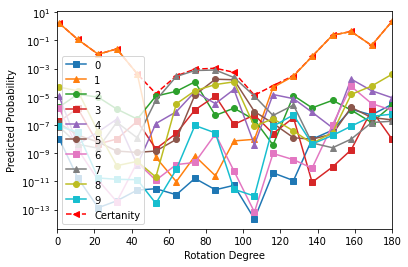

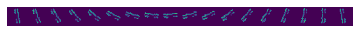

[1.684774, 0.118877426, 0.010446697, 0.025099777, 0.00042404947, 1.709822e-05, 0.00030606764, 0.00091905124, 0.0010624992, 0.00054995023, 1.3065878e-05, 6.1701656e-05, 0.0003175327, 0.0073545645, 0.23709308, 0.43235517, 0.044037566, 2.30327]


In [163]:
rotate_img_crossentropy(model2)